In [ ]:
!pip install faiss-gpu

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mpst-movie-plot-synopses-with-tags/partition.json
/kaggle/input/mpst-movie-plot-synopses-with-tags/mpst_full_data.csv
/kaggle/input/movies-genre-dataset-cmu-movie-summary/MovieSummaries/tvtropes.clusters.txt
/kaggle/input/movies-genre-dataset-cmu-movie-summary/MovieSummaries/movie.metadata.tsv
/kaggle/input/movies-genre-dataset-cmu-movie-summary/MovieSummaries/character.metadata.tsv
/kaggle/input/movies-genre-dataset-cmu-movie-summary/MovieSummaries/README.txt
/kaggle/input/movies-genre-dataset-cmu-movie-summary/MovieSummaries/plot_summaries.txt
/kaggle/input/movies-genre-dataset-cmu-movie-summary/MovieSummaries/name.clusters.txt
/kaggle/input/wikipedia-movie-plots/wiki_movie_plots_deduped.csv


In [2]:
mpst_movie=pd.read_csv('/kaggle/input/mpst-movie-plot-synopses-with-tags/mpst_full_data.csv')[['title','plot_synopsis']]

In [3]:
mpst_movie.rename(columns={'title':'Title','plot_synopsis':'Plot'},inplace=True)


In [4]:
mpst_movie

,Title,Plot
0,I tre volti della paura,Note: this synopsis is for the orginal Italian...
1,Dungeons & Dragons: The Book of Vile Darkness,"Two thousand years ago, Nhagruul the Foul, a s..."
2,The Shop Around the Corner,"Matuschek's, a gift store in Budapest, is the ..."
3,Mr. Holland's Opus,"Glenn Holland, not a morning person by anyone'..."
4,Scarface,"In May 1980, a Cuban man named Tony Montana (A..."
...,...,...
14823,Lucky Numbers,"In 1988 Russ Richards (John Travolta), the wea..."
14824,Iron Man 2,"In Russia, the media covers Tony Stark's discl..."
14825,Play Dirty,During the North African Campaign in World War...
14826,High Wall,Steven Kenet catches his unfaithful wife in th...


In [5]:
wiki_movie=pd.read_csv('/kaggle/input/wikipedia-movie-plots/wiki_movie_plots_deduped.csv')[['Title','Plot']]


In [6]:
final_movie_data=pd.concat([wiki_movie,mpst_movie],axis=0).drop_duplicates(subset=['Title']).reset_index(drop=True)

In [7]:
word_counts=[len(plot) for plot in final_movie_data['Plot']]

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

/tmp/ipykernel_130/408850486.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(final_movie_data['doc_len'], hist=True, kde=True, color='b', label='doc len')
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


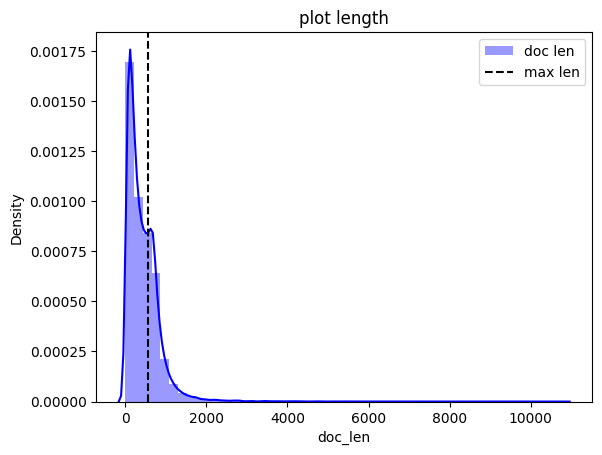

In [9]:
final_movie_data['doc_len'] = final_movie_data['Plot'].apply(lambda words: len(words.split()))
max_seq_len = np.round(final_movie_data['doc_len'].median() + np.median(abs(final_movie_data['doc_len'].median()-final_movie_data['doc_len']))).astype(int)
sns.distplot(final_movie_data['doc_len'], hist=True, kde=True, color='b', label='doc len')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.title('plot length'); plt.legend()
plt.show()

In [10]:
pip install sentence_transformers

Note: you may need to restart the kernel to use updated packages.


In [11]:
from sentence_transformers import SentenceTransformer, util
import torch

/opt/conda/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [12]:
def create_embeddings(data:list,model_name:str='sentence-transformers/msmarco-distilbert-dot-v5'):
    model=SentenceTransformer(model_name)
    # Start the multi-process pool on all available CUDA devices
    pool = model.start_multi_process_pool()

    # Compute the embeddings using the multi-process pool
    doc_embedding = model.encode_multi_process(data, pool)
    print("Embeddings computed. Shape:", doc_embedding.shape)

    # Optional: Stop the processes in the pool
    model.stop_multi_process_pool(pool)
    return doc_embedding

In [14]:
import faiss

In [57]:
def create_index(doc_embedding) -> np.ndarray:
    res = faiss.StandardGpuResources()
    index = faiss.GpuIndexFlatIP(res, doc_embedding.shape[1])
    index.add(doc_embedding)
    return index

def search_topk(index,model:SentenceTransformer,df:pd.DataFrame,query:str,k=10):
    top_k=index.search(model.encode([query]),k=k)
    return df.iloc[top_k[1].tolist()[0]]

In [16]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch
tokenizer = T5Tokenizer.from_pretrained('BeIR/query-gen-msmarco-t5-large-v1')
model = T5ForConditionalGeneration.from_pretrained('BeIR/query-gen-msmarco-t5-large-v1')
model.eval()

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


T5ForConditionalGeneration(
  (shared): Embedding(32128, 1024)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 1024)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=1024, out_features=1024, bias=False)
              (k): Linear(in_features=1024, out_features=1024, bias=False)
              (v): Linear(in_features=1024, out_features=1024, bias=False)
              (o): Linear(in_features=1024, out_features=1024, bias=False)
              (relative_attention_bias): Embedding(32, 16)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=1024, out_features=4096, bias=False)
              (wo): Linear(in_features=4096, out_features=1024, bias=False)
              (d

In [17]:
device=torch.device('cuda')

In [18]:
model.to(device)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 1024)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 1024)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=1024, out_features=1024, bias=False)
              (k): Linear(in_features=1024, out_features=1024, bias=False)
              (v): Linear(in_features=1024, out_features=1024, bias=False)
              (o): Linear(in_features=1024, out_features=1024, bias=False)
              (relative_attention_bias): Embedding(32, 16)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=1024, out_features=4096, bias=False)
              (wo): Linear(in_features=4096, out_features=1024, bias=False)
              (d

In [19]:
from tqdm import tqdm
# Parameters for generation

paragraphs=final_movie_data.Plot.tolist()
batch_size = 16 #Batch size
num_queries = 5 #Number of queries to generate for every paragraph
max_length_paragraph = 512 #Max length for paragraph
max_length_query = 64   #Max length for output query
def _removeNonAscii(s): return "".join(i for i in s if ord(i) < 128)

In [21]:
import torch
torch.cuda.empty_cache()
with open('generated_queries_all.tsv', 'w') as fOut:
    for start_idx in tqdm(range(0, len(paragraphs), batch_size)):
        sub_paragraphs = paragraphs[start_idx:start_idx+batch_size]
        inputs = tokenizer(sub_paragraphs, max_length=max_length_paragraph, padding=True, truncation=True, return_tensors='pt').to('cuda')
        outputs = model.generate(
            **inputs,
            max_length=max_length_query,
            do_sample=True,
            top_p=0.95,
            num_return_sequences=num_queries)

        for idx, out in enumerate(outputs):
            query = tokenizer.decode(out, skip_special_tokens=True)
            query = _removeNonAscii(query)
            para = sub_paragraphs[int(idx/num_queries)]
            para = _removeNonAscii(para)
            fOut.write("{}\t{}\n".format(query.replace("\t", " ").strip(), para.replace("\t", " ").strip()))

100%|██████████| 2391/2391 [4:48:31<00:00,  7.24s/it]  


In [47]:
from sentence_transformers import SentenceTransformer, InputExample, losses, models, datasets
from torch import nn
import os
import random

train_examples = [] 
with open('/kaggle/working/generated_queries_all.tsv') as fIn:
    for line in fIn:
        try:
            query, paragraph = line.strip().split('\t', maxsplit=1)
            train_examples.append(InputExample(texts=[query, paragraph]))
        except:
            pass
        
random.shuffle(train_examples)
train_dataloader = datasets.NoDuplicatesDataLoader(train_examples, batch_size=8)
word_emb = models.Transformer('sentence-transformers/msmarco-distilbert-dot-v5')
pooling = models.Pooling(word_emb.get_word_embedding_dimension())
model = SentenceTransformer(modules=[word_emb, pooling])
train_loss=losses.MultipleNegativesRankingLoss(model)
num_epochs = 1
warmup_steps = int(len(train_dataloader) * num_epochs * 0.1)
model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=num_epochs, warmup_steps=warmup_steps, show_progress_bar=True)

os.makedirs('search', exist_ok=True)
model.save('search/search-model')

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Step,Training Loss
500,0.397100
1000,0.400400
1500,0.389500
2000,0.393000
2500,0.378500
3000,0.396200
3500,0.406500
4000,0.390500
4500,0.414100
5000,0.402500


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

In [55]:
new_embeddings=create_embeddings(final_movie_data['Plot'].tolist(),model_name='search/search-model')

Chunks:   0%|          | 0/20 [00:00<?, ?it/s]

Embeddings computed. Shape: (38254, 768)


In [104]:
index=create_index(new_embeddings)

search_topk(index=index,model=model,df=final_movie_data,query="Ghost near a well ring",k=20)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

,Title,Plot,doc_len
31676,Hantu Gangster,"In a small town located in Klang, a rogue name...",104
29192,Aaaah,"Three friends (Gokul, Meghna and Bala) meeting...",360
21981,Troublesome Night 8,Bud Pit and his family leave the city and move...,126
37904,La rosa di Bagdad,"A long time ago, the people of Baghdad lived h...",665
38062,Superman and the Mole-Men,Mild-mannered reporter Clark Kent and Lois Lan...,498
5310,Superman and the Mole Men,Mild-mannered reporter Clark Kent and Lois Lan...,498
15648,Abandoned Mine,Five friends explore a supposedly haunted mine...,39
23475,Guest House,"Christopher, a lustful man goes to a remote vi...",50
8572,Charley Varrick,Charley Varrick is a crop-duster and former st...,612
36211,A Haunting at Silver Falls,The movie starts with a young girl running thr...,247


In [101]:
final_movie_data.loc[35479].Plot

"The series follows the continuing adventures of the four Ghostbusters, their secretary Janine, their accountant Louis, and their mascot Slimer, as they chase and capture rogue spirits around New York and various other areas of the world.\n=== Slimer! ===\nAt the start of the fourth season in 1988, the show was retitled to Slimer! and the Real Ghostbusters. It aired in a one-hour time slot, which the show began doing under its original name earlier that same year in January. In addition to the regular thirty-minute Real Ghostbusters episode, a half-hour Slimer sub-series was added that included 2–3 short animated segments focusing on the character Slimer. Animation for the Slimer! cartoons was handled by Wang Film Productions. At the end of its seven-season run, 147 episodes had aired, including the syndicated episodes and 13 episodes of Slimer, with multiple episodes airing out of production order.\nSlimer is shown to haunt the Sedgewick Hotel as its recurring pest. The segments added

In [105]:
final_movie_data.to_csv('Movies.csv')